In [2]:
# Load packages
import pandas as pd
import numpy as np
import time
import pytz
import matplotlib.pyplot as plt

import lxml.html as lx
import requests
import requests_cache

import newspaper
from newspaper import Article
from newspaper import news_pool

import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
import re

from sklearn.feature_extraction.text import CountVectorizer

import pickle

plt.rcParams["figure.figsize"] = [10, 8]

Useful links for newspaper3k:
https://opendatascience.com/using-the-newspaper-library-to-scrape-news-articles/
https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/

In [2]:
# Test the newspaper function.
link = "https://www.nytimes.com/2019/02/28/business/energy-environment/pge-camp-fire.html"
#link = 'https://krcrtv.com/news/butte-county/highway-70-to-be-closed-for-emergency-camp-fire-repairs'
#link = "http://krcrtv.com/news/butte-county/hundreds-of-trips-made-per-day-from-paradise-to-oroville-and-wheatland-with-debris"
#link = "https://krcrtv.com/news/camp-fire/camp-fire-debris-removal-could-be-halted-due-to-weather-cal-recycle-says"
article = Article(link)
article.download()
article.parse()
article.text

'Pacific Gas & Electric said Thursday that its equipment had probably caused the Camp Fire, the catastrophic November blaze that destroyed thousands of homes in Paradise, Calif., and killed at least 86 people.\n\nPG&E, which filed for bankruptcy protection in January, said it had recorded a $10.5 billion charge in anticipation of damage claims for that fire, the deadliest in state history. Largely as a result, the company reported a $6.9 billion loss for 2018.\n\nThough the cause of the fire is still under official investigation by California officials, PG&E said it “believes it is probable that its equipment will be determined to be an ignition point of the 2018 Camp Fire.” Attempts to determine the fire’s cause center on the 56-mile Caribou-Palermo electric transmission line.\n\nThe California Department of Forestry and Fire Protection has said the fire started at 6:33 a.m. on Nov. 8 near a tower on that line. PG&E said that its line de-energized at 6:15 a.m., adding that 15 minutes 

In [3]:
# Get google news links for each search term
search_term_links = [
    "https://news.google.com/search?q=camp%20fire&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20death%20toll&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20california&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20paradise&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20map&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20news&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20cleanup&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20debris%20removal&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20pg&e&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20investigation&hl=en-US&gl=US&ceid=US%3Aen"
]

In [4]:
# Get article links
def get_links(url):
    """Gets the article links for one Chronicle article list. The parameter "url" is the url to the 
    article list."""
    
    response = requests.get(url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    # Get the links that contain the word "article".
    #links = html.xpath("//div/a/@href")
    links = html.xpath("//*[contains(@class, 'NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')]/a/@href")

    return links

In [7]:
# Get article links for each search term
l = [get_links(l) for l in search_term_links]

# Unlist the links and get the unique links.
links = [item for sublist in l for item in sublist]
links = np.unique(links)

len(links)

683

In [9]:
# Extract text and publish data for the urls

def get_article_info(link):
    """Extract the title, text, publish date from a news article. The parameter link is the article link.
    Returns a dictionary of title, text, publish date, and url."""
    
    # Do not get the images.
    article = Article(link, fetch_images = False)
    
    # Not all articles can be downloaded/parsed.
    try:
        article.download()
        article.parse()
        
        title = article.title
        text = article.text # was in a try/except block
        date = article.publish_date
    except:
        # If article can't be parsed, set the variables to None.
        title = None
        text = None
        date = None
    
    url = link
    
    res = {"url": url, 
           "title": title, 
           "text": text,
           "date": date}
    
    return res

In [13]:
# test it
link = links[1]
get_article_info(link)

{'url': 'https://news.google.com/articles/CAIiEA8lz5KOarhC6TMal6EfYscqGQgEKhAIACoHCAowsIv_CjCag_gCMN-15QU',
 'title': 'Camp Fire Death Toll Drops to 85 After Testing Shows Remains of 1 Victim Were Separated; Only 11 People Still Missing',
 'text': '× Camp Fire Death Toll Drops to 85 After Testing Shows Remains of 1 Victim Were Separated; Only 11 People Still Missing\n\nThe sheriff in a Northern California county where dozens were killed by a deadly wildfire says only 11 people remain on a list of missing people.\n\nThe number of missing in Butte County at one point hit 1,300 amid the chaos and confusion after the Nov. 8 Camp Fire.\n\nSheriff Kory Honea says officials will work to track down the remaining people in the coming days.\n\nOn Monday, he also revised down the number of dead. He says 85 have died in the blaze, not 88 as previously reported. Honea says DNA testing showed remains that had been separated belonged to a single person.',
 'date': datetime.datetime(2018, 12, 4, 5, 4,

In [179]:
# Convert the article list to a dataframe.
articles = pd.DataFrame(article_list)

# Remove articles where we could not extract the the text.
articles = articles[~articles["text"].isna()]

# Convert the date column to datetime type
articles["date"] = pd.to_datetime(articles["date"], utc = True)

# Remove articles from paradise post (because this is from our local news source and we don't want overlap).
articles = articles[~articles["url"].str.contains("paradisepost")]

In [14]:
# Extract article info. Returns a list of dictionaries.
# article_list = [get_article_info(x) for x in links]

# Save the dataframe
# articles.to_pickle("articles.txt")

# I saved the article dataframe with pickle so that I don't have to extract the article info again.
articles = pd.read_pickle("articles.txt")
articles.head()

,date,text,title,url
0,2018-07-30 00:00:00+00:00,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,http://fortune.com/2018/07/30/mendocino-comple...
1,2018-11-08 00:00:00+00:00,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",http://fortune.com/2018/11/08/california-fires...
2,2018-11-30 00:00:00+00:00,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,http://fortune.com/2018/11/30/california-parad...
3,2018-12-07 00:00:00+00:00,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,http://fortune.com/2018/12/07/360-degree-video...
4,2019-02-11 00:00:00+00:00,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,http://fortune.com/2019/02/11/pge-reshapes-boa...


In [78]:
# Only keep the title and text in this dataframe so we can merge all three news sources.
articles_gn = articles.loc[:,['text', 'title']]
articles_gn["title"] = articles_gn["title"].str.replace("\n","")
articles_gn["source"] = "Google News"
articles_gn

# Save the dataframe
#articles_gn.to_pickle("articles_gn.txt")
articles_gn = pd.read_pickle("articles_gn.txt")
articles_gn.head()

,text,title,source
0,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,Google News
1,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",Google News
2,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,Google News
3,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,Google News
4,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,Google News


In [15]:
# Sort the dates to see how far back the articles go.
articles["date"].sort_values().dropna().head()

392   2018-01-14 00:00:00+00:00
0     2018-07-30 00:00:00+00:00
651   2018-08-07 00:00:00+00:00
404   2018-08-12 00:00:00+00:00
464   2018-08-20 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]

In [16]:
def tokenize_text(df):
    """Combine the strings in the "text" column of dataframe df into one long string. Then, tokenize the
    string and make all words lowercase."""
    
    # Combine the "text" column into a string.
    doc = ' '.join(df['text'].tolist())

    # Tokenize and make lowercase.
    words = nltk.word_tokenize(doc)
    words = [w.lower() for w in words]
    
    return words

In [17]:
# I took this function from Nick's lecture 2/14. It is for lemmitization.
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [18]:
def lemmatize_text(words):
    """Lemmatize words to get the base words. The input 'words' is a list of of words."""
    
    lemmatizer = nltk.WordNetLemmatizer()
    word_tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in word_tags]
    
    return words

In [19]:
def remove_stopwords(words):
    """Remove stopwords from a string."""
    
    stopwords = nltk.corpus.stopwords.words("english")
    words = [w for w in words if w not in stopwords]
    
    return words

In [20]:
# Tokenize, lemmatize, and remove stopwords for the text of all articles.
words = tokenize_text(articles)
words = lemmatize_text(words)
words = remove_stopwords(words)
words = [w for w in words if w.isalnum()]

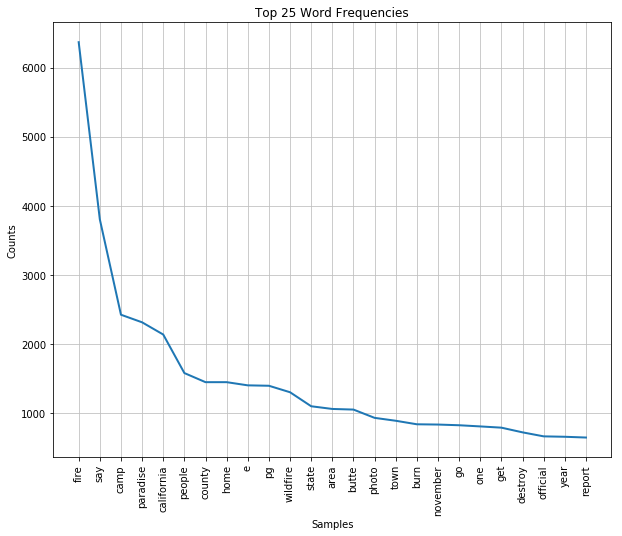

In [21]:
# Create a frequency plot.
fq = nltk.FreqDist(w for w in words if w.isalnum())
fq.plot(25, title = "Top 25 Word Frequencies")

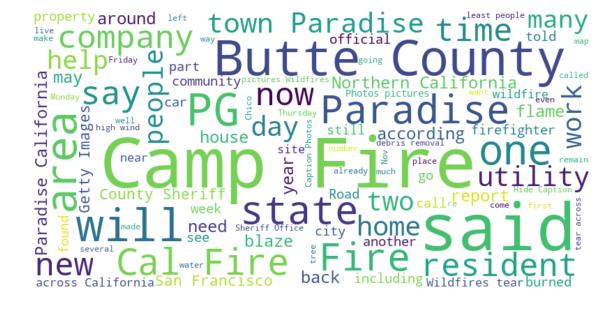

In [22]:
# Word cloud for all word articles we extracted from Google News.
doc = ' '.join(articles['text'].tolist())
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
# This function is for cleaning the text for tfidf.
# I adapted this function from http://brandonrose.org/clustering so that it lemmitizes the words as well.

def tokenize_and_lem(text):
    """Tokenizes and lemmatizes a string. The input is a single string. The output is a list of words that
    has been tokenized and lemmatized."""
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    lem = lemmatize_text(filtered_tokens)
    return lem


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Generate the tfidf matrix for all google articles combined.
text_list = articles['text'].tolist()
vec = TfidfVectorizer(max_df = 0.8, min_df=0.2,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [53]:
# Show tfidf dimensions.
tfidf

<644x117 sparse matrix of type '<class 'numpy.float64'>'
	with 22840 stored elements in Compressed Sparse Row format>

In [54]:
# Show some of the terms in the tfidf.
terms = vec.get_feature_names()
terms[:10]

["'s",
 'accord',
 'acre',
 'add',
 'agency',
 'area',
 'begin',
 'blaze',
 'burn',
 'butte']

In [55]:
# Tfidf for bigrams
text_list = articles['text'].tolist()
vec_bigram = TfidfVectorizer(min_df=0.1,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True,
                      ngram_range=(2,2))
tfidf_bigram = vec_bigram.fit_transform(text_list)

In [56]:
# Show some of the terms from the bigram tfidf
terms_bigram = vec_bigram.get_feature_names()
terms_bigram[:10]

['butte county',
 'california department',
 'california history',
 'california s',
 'california wildfire',
 'county sheriff',
 'deadly wildfire',
 'death toll',
 'debris removal',
 'destroy home']

In [162]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

In [163]:
dist

array([[-2.22044605e-16,  2.69647811e-01,  8.59734958e-01, ...,
         8.29895903e-01,  6.68508646e-01,  6.67599801e-01],
       [ 2.69647811e-01, -4.44089210e-16,  7.01214494e-01, ...,
         7.38011684e-01,  7.32429813e-01,  6.04742722e-01],
       [ 8.59734958e-01,  7.01214494e-01, -2.22044605e-16, ...,
         8.30384068e-01,  9.63254099e-01,  8.77356211e-01],
       ...,
       [ 8.29895903e-01,  7.38011684e-01,  8.30384068e-01, ...,
         0.00000000e+00,  9.32731799e-01,  8.76681811e-01],
       [ 6.68508646e-01,  7.32429813e-01,  9.63254099e-01, ...,
         9.32731799e-01,  0.00000000e+00,  9.10407929e-01],
       [ 6.67599801e-01,  6.04742722e-01,  8.77356211e-01, ...,
         8.76681811e-01,  9.10407929e-01,  0.00000000e+00]])

In [58]:
# Sample
articles.sample(5)

,date,text,title,url
377,2019-02-25 00:00:00+00:00,A group of architecture students from Cal Poly...,Architecture Students Reimagine Paradise In Af...,https://www.kpbs.org/news/2019/feb/25/architec...
83,NaT,(TNS) — The long road to recovery in the town ...,Millions of Tons of Camp Fire Debris Must Go S...,http://www.govtech.com/em/disaster/Millions-of...
530,NaT,The death toll in the Camp Fire rose to 88 Mon...,"Camp Fire: Death toll reaches 88, with 203 sti...",https://www.sacbee.com/latest-news/article2222...
76,2019-02-20 02:33:11+00:00,BUTTE VALLEY — Caltrans is putting in a rounda...,Roundabout going in at Clark and Durham-Pentz ...,http://www.chicoer.com/roundabout-going-in-at-...
512,2018-11-13 00:00:00+00:00,Search team members move sheet metal to allow ...,Camp Fire update: 10 people remain missing; th...,https://www.redding.com/story/news/local/2018/...
